In [1]:
%matplotlib inline

In [2]:
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn
import sklearn.linear_model
from datetime import datetime, date
from sklearn_pandas import DataFrameMapper
import warnings
import timeit
from collections import defaultdict, OrderedDict
import tabulate
import time
import GPy
from IPython.display import display
import scipy
from scipy import stats

timeit.template = """
def inner(_it, _timer{init}):
    {setup}
    _t0 = _timer()
    for _i in _it:
        retval = {stmt}
    _t1 = _timer()
    return _t1 - _t0, retval
"""

matplotlib.style.use('ggplot')

RANDOM_SEED = 33

In [21]:
from scipy import stats
from numpy import random 


def p(x):
    return stats.norm.pdf(x, -4, 0.5) + stats.norm.pdf(x, 4, 1)


def q(x, prev_x, epsilon):
    return stats.norm.pdf(x, prev_x, epsilon)


def rq(prev_x, epsilon, size=1):
    return random.normal(prev_x, epsilon, size)


def second_rq(prev_x, epsilon, size=1):
    return random.normal(-1 * prev_x, epsilon, size)


def mcmc(t_max, epsilon, x0=0, rq=rq):
    # The normal distribution is symmetric
    # Allowing to eschew the ration of q(x, x') and q(x', x) terms
    results = [x0]
    accepted_count = 0
    for t in range(t_max):
        x_prev = results[-1]
        x_new = rq(x_prev, epsilon)[0]
        a = p(x_new) / p(x_prev)
        accepted = random.uniform() < a
        
        accepted_count += accepted
        results.append(x_new if accepted else x_prev)
            
    return results, accepted_count / t_max

In [19]:
def plot_sample_correlation(results, acceptance_ratio, epsilon, ax=None):
    should_show = False
    
    if ax is None:
        should_show = True
        fig = plt.figure(figsize=(12, 9))
        ax = fig.add_subplot(111) 
    
    t_values = list(range(len(results)))
    ax.plot(results, t_values, alpha=0.5)
    ax.set_xlabel(r'x')
    ax.set_ylabel(r't')
    ax.set_title(r'$\epsilon = {epsilon}$, rate {a:.2f}'.format(
        epsilon=epsilon, a=acceptance_ratio))

    if should_show:
        plt.show()
        
def plot_sample_histogram(results, acceptance_ratio, epsilon, ax=None):
    should_show = False
    
    if ax is None:
        should_show = True
        fig = plt.figure(figsize=(12, 9))
        ax = fig.add_subplot(111) 
    
    x_values = np.linspace(-6, 8, 100)
    ax.plot(x_values, p(x_values), label='$p(x)$', color='black')

    ax.hist(results, density=True)
    ax.set_xlabel(r'x')
    ax.set_ylabel(r'Frequency')
    ax.set_title(r'$\epsilon = {epsilon}$, rate {a:.2f}'.format(
        epsilon=epsilon, a=acceptance_ratio))

    if should_show:
        plt.show()

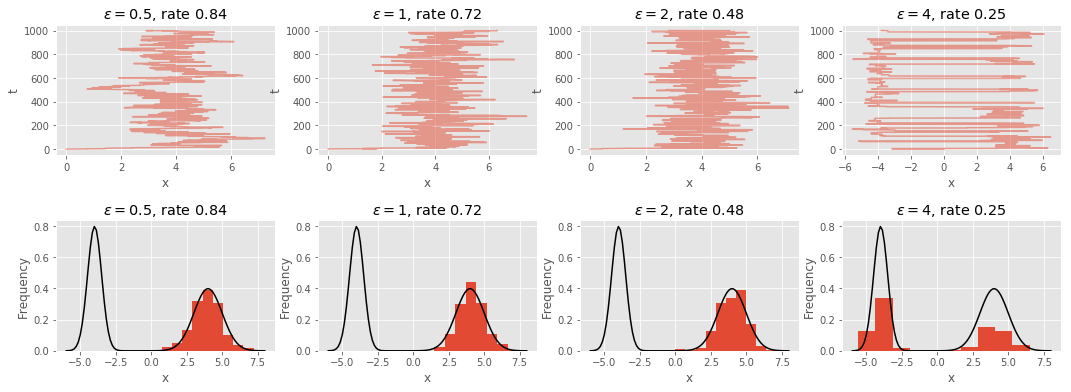

In [20]:
EPSILON_VALUES = (0.5, 1, 2, 4)
T_MAX = 1000
X_0 = 0

fig = plt.figure(figsize=(18, 6))
gs = gridspec.GridSpec(2, 4, hspace=0.5)

for index, epsilon in enumerate(EPSILON_VALUES):
    results, acceptance_ratio = mcmc(T_MAX, epsilon, X_0)
    plot_sample_correlation(results, acceptance_ratio, epsilon, plt.subplot(gs[0, index]))
    plot_sample_histogram(results, acceptance_ratio, epsilon, plt.subplot(gs[1, index]))

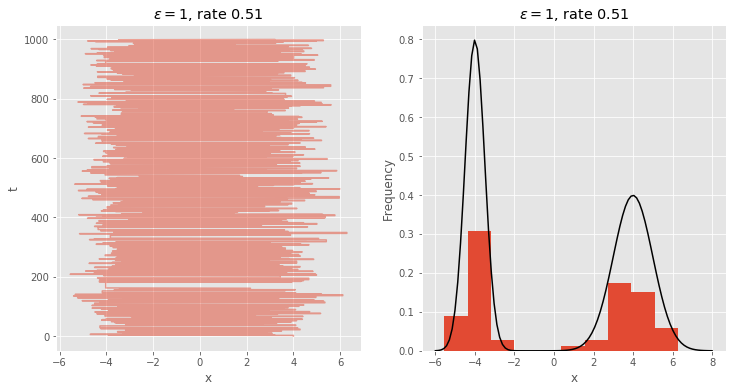

In [22]:
epsilon = 1

r, a = mcmc(T_MAX, epsilon, 4, second_rq)
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 2, hspace=0.5)

plot_sample_correlation(r, a, epsilon, plt.subplot(gs[0, 0]))
plot_sample_histogram(r, a, epsilon, plt.subplot(gs[0, 1]))